# Face landmarks Detection Starter Pack by Bongsang

### Step 1. Data Analysis and dataset making

The first step is to load in the images of faces and their keypoints and visualize them.
This set of image data has been extracted from the [YouTube Faces Dataset](https://www.cs.tau.ac.il/~wolf/ytfaces/), which includes videos of people in YouTube videos. These videos have been fed through some processing steps and turned into sets of image frames containing one face and the associated keypoints.

<img src="https://www.cs.tau.ac.il/~wolf/ytfaces/logo.jpg" width=50%>

### Training and Testing Data

This facial landmarks dataset consists of 5,770 images. All of these images are separated into either a training or a test set of data.

Total | Training | Testing
----- | -------- | -------
5,770 | 3,462    | 2,308
100%  | 60%      | 40%

The information about the images and keypoints in this dataset are summarized in CSV files, which we can read in using `pandas`. Let's read the training CSV and get the annotations in an (N, 2) array where N is the number of keypoints and 2 is the dimension of the keypoint coordinates (x, y).

---

In [1]:
import pandas as pd
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt


# import glob

# import skimage.io as io
# from torch.utils.data import DataLoader
# from torchvision import transforms, utils

# # Bongsang's personal pacakges
# from landmarks_dataset import LandmarksDataset
# from landmarks_transform import Rescale, RandomCrop, Normalize, ToTensor

%matplotlib inline

In [2]:
## Debug On/Off
# debug = True
debug = False

In [3]:
landmarks_frame = pd.read_csv('data/training_landmarks.csv')
print(f'The number of training dataset is {len(landmarks_frame)}. {3462/5770*100}% of 5,770')
landmarks_frame.head()

The number of training dataset is 3462. 60.0% of 5,770


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


#### Plotting some images from data frame

In [4]:
def get_image_name(frame, idx):
    return frame.iloc[idx, 0]

def get_landmarks(frame, idx):
    landmark_points = frame.iloc[idx, 1:].to_numpy()
    landmark_points = landmark_points.astype('float').reshape(-1, 2)
    return landmark_points

def show_landmarks(image, points, name):
    plt.title(name)
    plt.imshow(image)
    plt.scatter(points[:, 0], points[:, 1], s=20, marker='.', c='m')
    plt.pause(0.1)

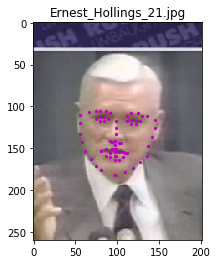

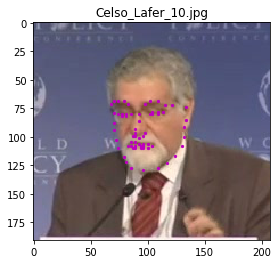

In [5]:
for _ in range(2):
    idx = np.random.randint(0, len(landmarks_frame))
    image_name = get_image_name(landmarks_frame, idx)
    image_path = os.path.join('data/training/', image_name)
    image = cv2.imread(image_path)
    image_data = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    landmarks = get_landmarks(landmarks_frame, idx)
    show_landmarks(image_data, landmarks, image_name)

## Dataset class and Transformations

To prepare our data for training, we'll be using PyTorch's Dataset class. Much of this this code is a modified version of what can be found in the [PyTorch data loading tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

<img src="https://pytorch.org/tutorials/_images/landmarked_face2.png" width=25%>

### PyTorch Dataset class

``torch.utils.data.Dataset`` is an abstract class representing a
dataset. This class will allow us to load batches of image/keypoint data, and uniformly apply transformations to our data, such as rescaling and normalizing images for training a neural network.


Your custom dataset should inherit ``Dataset`` and override the following
methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get the i-th sample of image/keypoint data.

Let's create a dataset class for our face keypoints dataset. We will
read the CSV file in ``__init__`` but leave the reading of images to
``__getitem__``. This is memory efficient because all the images are not
stored in the memory at once but read as required.

A sample of our dataset will be a dictionary
``{'image': image, 'keypoints': key_pts}``. Our dataset will take an
optional argument ``transform`` so that any required processing can be
applied on the sample. We will see the usefulness of ``transform`` in the
next section.


In [6]:
import torch
from torch.utils.data import Dataset

class LandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = self.landmarks_frame.iloc[idx, 0]
        image_path = os.path.join(self.root_dir, image_name)
        image = cv2.imread(image_path)
        image_data = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image_data, 'landmarks': landmarks, 'name': image_name}
        if debug:
            print(f'LandmarksDataset shape, file={image_name}, image={image_data.shape}, landmarks={landmarks.shape}')


        if self.transform:
            sample = self.transform(sample)

        return sample

#### Plotting some images from PyTorch dataset

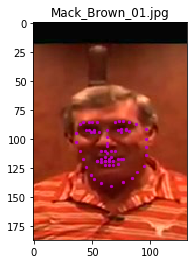

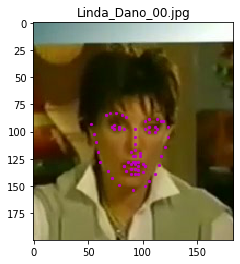

In [7]:
landmarks_dataset = LandmarksDataset(csv_file='data/training_landmarks.csv',
                                    root_dir='data/training',
                                    transform=None)
for _ in range(2):
    idx = np.random.randint(0, len(landmarks_dataset))
    sample = landmarks_dataset[idx]
    show_landmarks(sample['image'], sample['landmarks'], sample['name'])

## PyTorch Transforms

Now, the images above are not of the same size, and neural networks often expect images that are standardized; a fixed size, with a normalized range for color ranges and coordinates, and (for PyTorch) converted from numpy lists and arrays to Tensors.

Therefore, we will need to write some pre-processing code.
Let's create four transforms:

-  ``Normalize``: to convert a color image to grayscale values with a range of [0,1] and normalize the keypoints to be in a range of about [-1, 1]
-  ``Rescale``: to rescale an image to a desired size.
-  ``RandomCrop``: to crop an image randomly.
-  ``ToTensor``: to convert numpy images to torch images.


We will write them as callable classes instead of simple functions so
that parameters of the transform need not be passed everytime it's
called. For this, we just need to implement ``__call__`` method and 
(if we require parameters to be passed in), the ``__init__`` method. 
We can then use a transform like this:

    tx = Transform(params)
    transformed_sample = tx(sample)

Observe below how these transforms are generally applied to both the image and its keypoints.



In [8]:
class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""

    def __call__(self, sample):
        image, landmarks, name = sample['image'], sample['landmarks'], sample['name']


        image_copy = np.copy(image)
        landmarks_copy = np.copy(landmarks)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)

        # scale color range from [0, 255] to [0, 1]
        image_copy = image_copy / 255.0

        # scale landmarks to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        landmarks_copy = (landmarks_copy - 100) / 50.0

        if debug:
            print(f'Normalized LandmarksDataset, file={name}, rescaled shape = {image_copy.shape}')
        
        return {'image':image_copy, 'landmarks':landmarks_copy, 'name': name}



class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks, name = sample['image'], sample['landmarks'], sample['name']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        image_copy = cv2.resize(image, (new_w, new_h))
        landmarks_copy = landmarks * [new_w / w, new_h / h]
        
        if debug:
            print(f'Rescaled shape, file={name}, rescaled shape = {image_copy.shape}')

        return {'image':image_copy, 'landmarks':landmarks_copy, 'name': name}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks, name = sample['image'], sample['landmarks'], sample['name']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image_copy = image[top: top + new_h, left: left + new_w]
        landmarks_copy = landmarks - [left, top]

        if debug:
            print(f'Croped shape, file={name}, rescaled shape = {image_copy.shape}')

        return {'image':image_copy, 'landmarks':landmarks_copy, 'name': name}



class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks, name = sample['image'], sample['landmarks'], sample['name']


        
        # When use Normalize, the image shape dosen't include color channle so you have to reshape like below.
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
        
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W 
        image_copy = image.transpose((2, 0, 1))
        if debug:
            print(f'Transformed and changed to Tensor, file={name}, rescaled shape = {image_copy.shape}')

        return {'image': torch.from_numpy(image_copy), 'landmarks': torch.from_numpy(landmarks), 'name': name}

### Test out the transforms: Rescale any images to 250 size (height)

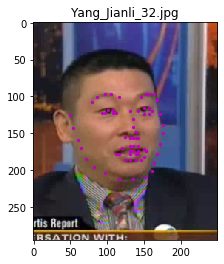

In [9]:
from torchvision import transforms
rescale = Rescale(250)

idx = np.random.randint(0, len(landmarks_dataset))
sample = landmarks_dataset[idx]
transformed_sample = rescale(sample)
show_landmarks(transformed_sample['image'], transformed_sample['landmarks'], transformed_sample['name'])

### Test out the transforms: Crop any images to 50 size

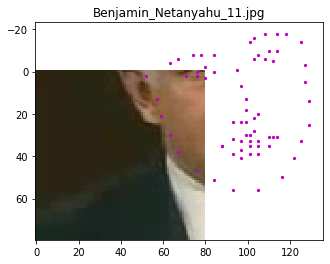

In [10]:
from torchvision import transforms
crop = RandomCrop(80)

idx = np.random.randint(0, len(landmarks_dataset))
sample = landmarks_dataset[idx]
transformed_sample = crop(sample)
show_landmarks(transformed_sample['image'], transformed_sample['landmarks'], transformed_sample['name'])

### Test out the transforms: Rescale to 250 size and then crop 224 size

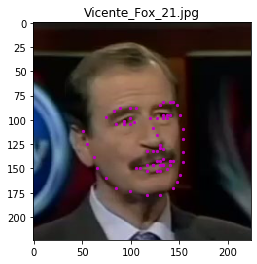

In [11]:
from torchvision import transforms
composed = transforms.Compose([Rescale(250), RandomCrop(224)])

idx = np.random.randint(0, len(landmarks_dataset))
sample = landmarks_dataset[idx]
transformed_sample = composed(sample)
show_landmarks(transformed_sample['image'], transformed_sample['landmarks'], transformed_sample['name'])

## Create the transformed dataset

Apply the transforms in order to get grayscale images of the same shape. Verify that your transform works by printing out the shape of the resulting data (printing out a few examples should show you a consistent tensor size).

In [61]:
# define the data tranform
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
#                                      Normalize(),  ## for faster training
                                     ToTensor()])

# create the transformed dataset
transformed_dataset = LandmarksDataset(csv_file='data/training_landmarks.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)

### Check all sizes

In [62]:
for i in range(3):
    idx = np.random.randint(0, len(transformed_dataset))
    sample = transformed_dataset[idx]
    print(f"{i}: {sample['name']}, image size={sample['image'].size()}, landmark size={sample['landmarks'].size()}")
    print('-'*100)

0: Nicolas_Sarkozy_52.jpg, image size=torch.Size([3, 224, 224]), landmark size=torch.Size([68, 2])
----------------------------------------------------------------------------------------------------
1: Clint_Howard_31.jpg, image size=torch.Size([3, 224, 224]), landmark size=torch.Size([68, 2])
----------------------------------------------------------------------------------------------------
2: Marieta_Chrousala_12.jpg, image size=torch.Size([3, 224, 224]), landmark size=torch.Size([68, 2])
----------------------------------------------------------------------------------------------------


## Data Iteration and Batch

Right now, we are iterating over this data using a ``for`` loop, but we are missing out on a lot of PyTorch's dataset capabilities, specifically the abilities to:

-  Batch the data
-  Shuffle the data
-  Load the data in parallel using ``multiprocessing`` workers.

``torch.utils.data.DataLoader`` is an iterator which provides all these
features, and we'll see this in use in the *next* notebook, Notebook 2, when we load data in batches to train a neural network!

In [63]:
from torch.utils.data import DataLoader

batch_num = 8
worker_num = 4
dataloader = DataLoader(transformed_dataset, batch_size=batch_num, shuffle=True, num_workers=worker_num)

### Bach sample check

In [64]:
from torchvision import utils

# Helper function to show a batch
def show_landmarks_batch(sample_batch):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = sample_batch['image'], sample_batch['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    print(f'batch shape = {images_batch.shape}')
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0))) # C*W*H --> W*H*C

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

0 torch.Size([8, 3, 224, 224]) torch.Size([8, 68, 2])
1 torch.Size([8, 3, 224, 224]) torch.Size([8, 68, 2])
2 torch.Size([8, 3, 224, 224]) torch.Size([8, 68, 2])
3 torch.Size([8, 3, 224, 224]) torch.Size([8, 68, 2])
4 torch.Size([8, 3, 224, 224]) torch.Size([8, 68, 2])
5 torch.Size([8, 3, 224, 224]) torch.Size([8, 68, 2])
6 torch.Size([8, 3, 224, 224]) torch.Size([8, 68, 2])
7 torch.Size([8, 3, 224, 224]) torch.Size([8, 68, 2])
batch shape = torch.Size([8, 3, 224, 224])


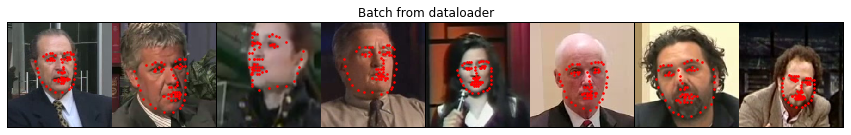

In [65]:
for i_batch, sample_batch in enumerate(dataloader):
    print(i_batch, sample_batch['image'].size(),
          sample_batch['landmarks'].size())

    # observe batch and stop.
    if i_batch == batch_num-1:
        plt.figure(figsize=(15, 10))
        show_landmarks_batch(sample_batch)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

---

## Step 2. Convolutional Neural Network

1. Define a CNN with images as input and landmarks as output
2. Train the CNN on the training data tracking loss
3. Evaluate how the trained model performs on test data
4. Try and Error! Update the CNN structure and model hyperparameters, so that it performs well enough.
---

In [66]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
# can use the below import should you choose to initialize the weights of your Net
import torch.nn.init as I

"""
https://pytorch.org/docs/stable/nn.html#conv2d
torch.nn.Conv2d(in_channels, out_channels, kernel_size, 
                stride=1, padding=0, dilation=1, groups=1,
                bias=True, padding_mode='zeros')
"""
def layer_out(inputs, kernel, stride=1, padding=0, dilation=1):
    return (inputs - kernel + 2*padding)//stride + 1


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## 1. This network takes in a square (same width and height), grayscale image as input
        ## 2. It ends with a linear layer that represents the landmarks
        ## it's suggested that you make this last layer output 136 values, 2 for each of the 68 keypoint (x, y) pairs
        ## As an example, input image channel (grayscale), 32 output channels/feature maps, 5x5 square convolution kernel
        
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size,
        #                stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        
        # Assume that input image size is 96 x 96 pixels
        self.image_width = 224
        self.n_classes = 136
        
        fc_inputs = 0
        self.kernel = 5
        self.stride = 2
        
        self.conv1 = nn.Conv2d(1, 32, self.kernel)
        # Convolution layer's output tensor = ((Width-Kernel)+2Padding)/Stride + 1 = (96-5+0)/1 + 1 = 92
        # (32, 92, 92)
        fc_inputs = layer_out(self.image_width, self.kernel)
        
        self.pool1 = nn.MaxPool2d(self.stride, self.stride)
        # Pooling layer's output tensor = W // S = 92/2 = 46
        # (32, 46, 46)
        fc_inputs = fc_inputs // self.stride
        
        self.conv2 = nn.Conv2d(32, 64, 5) # (46-5+0)/1 +1 = 42
        # (64, 42, 42)
        fc_inputs = layer_out(fc_inputs, self.kernel)
        
        self.pool2 = nn.MaxPool2d(2, 2) # 42/2 = 21
        # (64, 21, 21)
        fc_inputs = fc_inputs // self.stride
        print(f"final fully connected layer's input = {fc_inputs}")
        
        self.fc1 = nn.Linear(64*fc_inputs*fc_inputs, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, self.n_classes)

        self.dropout = nn.Dropout(p=0.2)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x

In [70]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

cnn = Net()
cnn.to(device)
print(cnn)

final fully connected layer's input = 53
Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=179776, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=136, bias=True)
  (dropout): Dropout(p=0.2)
)


## Step 3. Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

---

In [71]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(dataloader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        landmarks = sample['landmarks']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = cnn(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

        
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

RuntimeError: Given groups=1, weight of size [32, 1, 5, 5], expected input[8, 3, 224, 224] to have 1 channels, but got 3 channels instead

## Ready to Train!

Now that you've seen how to load and transform our data, you're ready to build a neural network to train on this data.

In the next notebook, you'll be tasked with creating a CNN for facial keypoint detection.

### Bongsang Kim
- homepage: https://bongsang.github.io
- Linkedin: https://www.linkedin.com/in/bongsang